### Business Usecase: 

SIB(Small Industries Bank) loans money to companies in exchange for the promise of repayment.  Some will default on the loans, being unable to repay them for some reason. The bank maintains insurance to reduce their risk of loss in the event of default. The insured amount may cover all or just some part of the loan amount.  SIB wants to predict which companies will default on their loans based on their financial information. They have provided you with a dataset that consists of loan related information such as loan amount, term, and state. Also, there is company information such as the number of employees, operating sector, etc.

### Project Scope:

Using machine learning, predict which companies will default on their loans and explain how different features impact the predictions.

Analyze the given data and learn how different features are related to and affect default_status. With the given data, build a machine learning model which can be used to predict the ‘default_status'.
 
For each record in the test set (test.csv), you must predict the value of the default_status variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:
•	id
•	default_status


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import linear_model
from sklearn import utils
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn import ensemble
import shap

In [2]:
data = pd.read_csv('data/train.csv')

# 1) Data Preparation and Insights

## 1.1) Data Processing

In [3]:
data.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


### 1.1.1) Handling nulls

In [4]:
null_data = data[data.isnull().any(axis=1)]
null_data

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
1946,3771775001,NaN,NH,20-Nov-09,12,1,New,0,Rural,N,$100.00,"$75,000.00",0


There is only one record which has missing industry and this record has 750x more insured amount than loan amount which appears to be an error and therefore, this row is dropped from all further analysis.

In [5]:
data = data.dropna()

### 1.1.2) Data Types Validation

In [6]:
data.dtypes

id                 int64
industry          object
state             object
request_date      object
term               int64
employee_count     int64
business_new      object
business_type      int64
location          object
other_loans       object
loan_amount       object
insured_amount    object
default_status     int64
dtype: object

columns id, default_status and business_type are categorical fields and therefore their data type will have to be converted to string. Columns loan_amount and insured_amount are numeric values and they have to be converted to float data type.

In [7]:
data[data.columns[10:12]] = data[data.columns[10:12]].replace('[\$,]', '', regex=True).astype(float)
data['business_type']=data['business_type'].apply(str)
data['default_status']=data['default_status'].apply(str)
data['id']=data['id'].apply(str)

### 1.1.3) Dropping Variables

Identifying the distinct count of values across all variables.

In [8]:
data.nunique()

id                2401
industry            16
state               50
request_date       271
term               155
employee_count      88
business_new         2
business_type        2
location             1
other_loans          2
loan_amount       1030
insured_amount     735
default_status       2
dtype: int64

Total number of rows in the dataset:

In [9]:
data.shape[0]

2401

It can be seen that every row has a unique id and therfore, the column 'id' can be dropped from the dataframe as it is not required for training the model. 'location' has only 1 distinct value and therfore even this column can be dropped as it will not help the model to diffrentiate.

In [10]:
data = data.drop(columns=['id'])
data = data.drop(columns=['location'])

request date is dropped as the time the customer reqested for loan in not necessary for the prediction. 

In [11]:
data=data.drop(columns=['request_date'])

## 1.2) Exploratory Data Analysis

Before performing feature engineering, lets understand the relationship between the independant variables and the target variable.

### 1.2.1) Customers Distribution

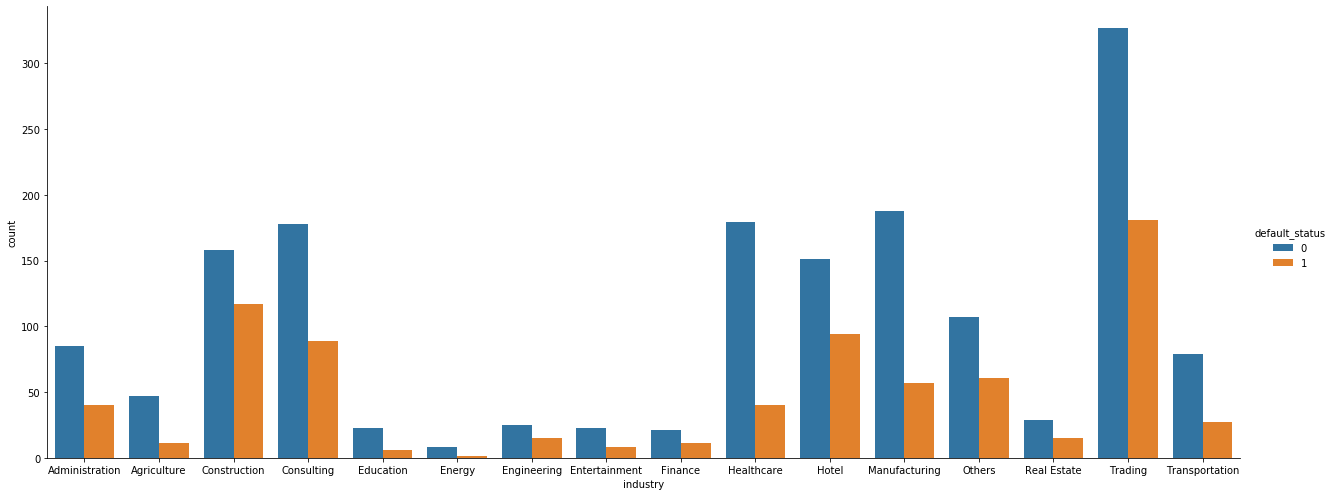

In [12]:
sub_data=data[['industry', 'default_status' ]]
industry_distribution=sub_data.groupby(["industry", "default_status"]).size().reset_index(name='count')
sns.catplot(x="industry", y="count",hue='default_status',
               data=industry_distribution, kind="bar",height=7,aspect=2.5)

From the plot above, it is visible that most customers are from trading industry and it also has the most number of defaulters.

### 1.2.2)  Proportion of Defaulting by Industry

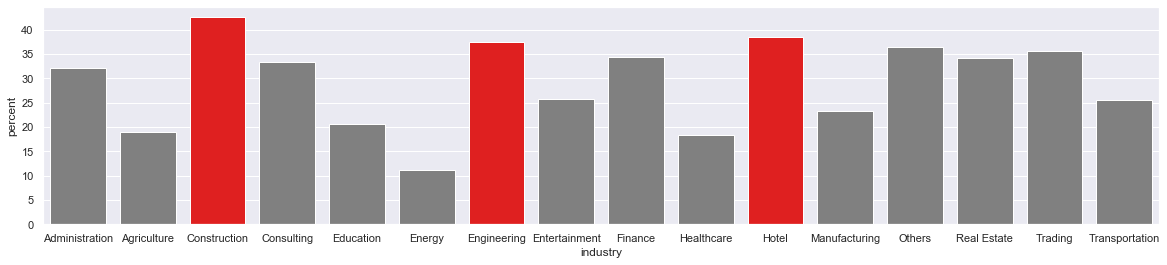

In [13]:
sub_data=data[['industry', 'default_status' ]]
sub_data=pd.DataFrame(sub_data)
tempdf=sub_data.groupby(['industry','default_status']).default_status.count().unstack()
tempdf['count']=sub_data['industry'].value_counts()
tempdf['percent']=tempdf['1']/tempdf['count']*100

tempdf.reset_index(inplace=True)
#print(tempdf)
sns.set(rc={'figure.figsize':(20,4)})
clrs = ['grey' if (x < tempdf['percent'].nlargest(3).iloc[2]) else 'red' for x in tempdf['percent'] ]
sns.barplot(x='industry',y='percent',data=tempdf,palette=clrs)


Among all the industries, construction has the highest proportion of defaulters.

### 1.2.3)  Insured Amount vs Defaulters


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


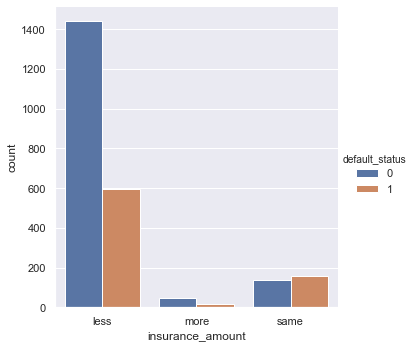

In [14]:
sub_data=data[['loan_amount', 'insured_amount','default_status']]
def conditions(sub_data):
    if (sub_data['insured_amount'] > sub_data['loan_amount']):
        return 'more'
    elif (sub_data['insured_amount'] == sub_data['loan_amount']):
        return 'same'
    else:
        return 'less'
    
sub_data['insurance_amount'] = sub_data.apply(conditions, axis=1)
industry_distribution=sub_data.groupby(["insurance_amount", "default_status"]).size().reset_index(name='count')
sns.catplot(x="insurance_amount", y="count",hue='default_status',
               data=industry_distribution, kind="bar",height=5)

Most cases, the insurance covered is less than the amount of loan. Customers who have the same insured amount as the loan amount defaulted more compared to those who had less or more insurance amount.

### 1.2.4) Term vs Loan Amount

An assumption is made that the term is the count of months and that the payments by the customers are to be made on a monthly basis.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'Estimated Monthly Payments')

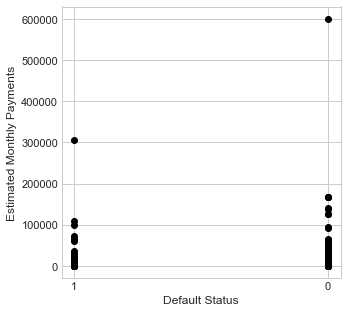

In [16]:
sub_data=data[['loan_amount', 'term','default_status']]
sub_data['estimated_monthly_payment']=sub_data['loan_amount']/sub_data['term']
plt.style.use('seaborn-whitegrid')
plt.plot(sub_data['default_status'],sub_data['estimated_monthly_payment'], 'o', color='black')
plt.xlabel("Default Status")
plt.ylabel("Estimated Monthly Payments")

The distribution of defaulters and non defaulters is almost similar. There appears to be two outlier points. However, they will not be removed as more business domain knowledge would be required to come to the couclusion.

### 1.2.5) Employee Count vs Defaulters

Text(0, 0.5, 'Employee Count')

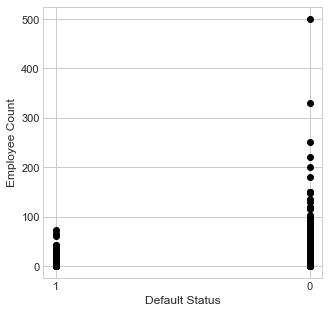

In [17]:
sub_data=data[['employee_count','default_status']]
plt.style.use('seaborn-whitegrid')
plt.plot(sub_data['default_status'],sub_data['employee_count'], 'o', color='black')
plt.xlabel("Default Status")
plt.ylabel("Employee Count")

Business customers who defaulted have employee count less than 100

### 1.2.6) Proportion of Defaulting on business new, type and other loans

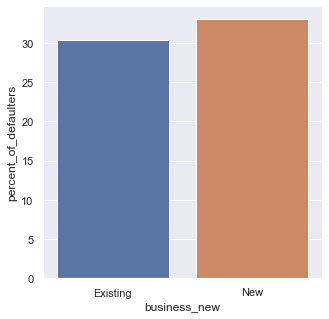

In [18]:
sub_data=data[['business_new', 'default_status' ]]
sub_data=pd.DataFrame(sub_data)
tempdf=sub_data.groupby(['business_new','default_status']).default_status.count().unstack()
tempdf['count']=sub_data['business_new'].value_counts()
tempdf['percent_of_defaulters']=tempdf['1']/tempdf['count']*100

tempdf.reset_index(inplace=True)
#print(tempdf)
sns.set(rc={'figure.figsize':(5,5)})
#clrs = ['grey' if (x < tempdf['percent'].nlargest(3).iloc[2]) else 'red' for x in tempdf['percent'] ]
sns.barplot(x='business_new',y='percent_of_defaulters',data=tempdf)

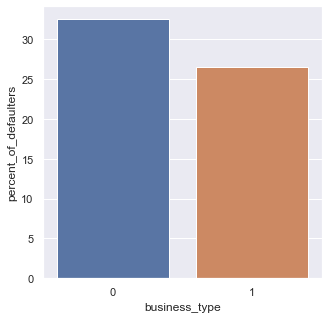

In [19]:
sub_data=data[['business_type', 'default_status' ]]
sub_data=pd.DataFrame(sub_data)
tempdf=sub_data.groupby(['business_type','default_status']).default_status.count().unstack()
tempdf['count']=sub_data['business_type'].value_counts()
tempdf['percent_of_defaulters']=tempdf['1']/tempdf['count']*100

tempdf.reset_index(inplace=True)
#print(tempdf)
sns.set(rc={'figure.figsize':(5,5)})
#clrs = ['grey' if (x < tempdf['percent'].nlargest(3).iloc[2]) else 'red' for x in tempdf['percent'] ]
sns.barplot(x='business_type',y='percent_of_defaulters',data=tempdf)

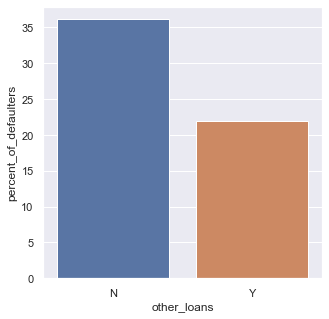

In [20]:
sub_data=data[['other_loans', 'default_status' ]]
sub_data=pd.DataFrame(sub_data)
tempdf=sub_data.groupby(['other_loans','default_status']).default_status.count().unstack()
tempdf['count']=sub_data['other_loans'].value_counts()
tempdf['percent_of_defaulters']=tempdf['1']/tempdf['count']*100

tempdf.reset_index(inplace=True)
#print(tempdf)
sns.set(rc={'figure.figsize':(5,5)})
#clrs = ['grey' if (x < tempdf['percent'].nlargest(3).iloc[2]) else 'red' for x in tempdf['percent'] ]
sns.barplot(x='other_loans',y='percent_of_defaulters',data=tempdf)

## 1.3) Observations

1) Trading industry is the biggest customer and Construction, Hotel and Engineering are the industries with the largest proportion of defaulters

2) Customers with same insured amount as their loan tend to default more

3) Monthly payment distribution across defaulters and non defaulters is similar

4) Smaller employee count companies default more than companies with higher employee count

5) Customers who have no other loan defaulted more than those who have other loans

6) Customers with business type =0 defaulted more that type 1

In [21]:
data['default_status'].value_counts()

0    1628
1     773
Name: default_status, dtype: int64

This is an imbalanced data set with only 1/3rd of the dataset consisting of defaulters

## 1.4) Feature Engineering

### 1.4.1) One Hot Encoding

Converting the categorical fields with 2 values into binary vectors with the help of one hot encoding. One hot encoding was preffered as there is no ordering among the values within each category

In [22]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['business_new', 'business_type','other_loans'])
one_hot_encoded_data

,industry,state,term,employee_count,loan_amount,insured_amount,default_status,business_new_Existing,business_new_New,business_type_0,business_type_1,other_loans_N,other_loans_Y
0,Others,VA,34,4,35000.0,35000.0,1,0,1,1,0,1,0
1,Manufacturing,CA,107,1,15000.0,13500.0,1,0,1,1,0,1,0
2,Trading,CA,84,1,265000.0,100000.0,0,0,1,1,0,0,1
3,Engineering,MI,240,21,255000.0,255000.0,0,0,1,1,0,1,0
4,Education,NH,36,1,13300.0,6650.0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,Trading,NC,55,7,35000.0,35000.0,1,0,1,1,0,1,0
2398,Manufacturing,WI,60,31,250000.0,187500.0,0,0,1,1,0,1,0
2399,Manufacturing,TX,240,35,564000.0,564000.0,0,0,1,1,0,1,0
2400,Manufacturing,RI,47,6,50000.0,25000.0,1,0,1,1,0,0,1


### 1.4.2) Target Encoding

Column state has 50 values and industry has 16 and performing one hot encoding will increase the sparsity of the dataset. Therefore, targeted encoding was used by substituting each group in the column with the average response in the target variables.

In [23]:
one_hot_encoded_data['default_status']=one_hot_encoded_data['default_status'].apply(int)

In [24]:
encodings1 = one_hot_encoded_data.groupby('industry')['default_status'].mean().reset_index()
encodings2 = one_hot_encoded_data.groupby('state')['default_status'].mean().reset_index()

encoded = one_hot_encoded_data.merge(encodings1, how='left', on='industry')
encoded = encoded.merge(encodings2, how='left', on='state')

encoded.drop('industry', axis=1, inplace=True)
encoded.drop('state', axis=1, inplace=True)

encoded.rename(columns = {'default_status_y':'industry','default_status_x':'default_status','default_status':'state'}, inplace = True)

### 1.4.3) Creating New Variables

From EDA, it was observed that customers with the same insurance and loan amount defaulted more. Instead of using amount values for 'insured_amount', the continuous values were converted to 3 categorical values 'less', 'more' and 'same'. However, this processing did not help the model training and therefore, another approach of calculating the difference between loan and insuared amount was used instead.

In [25]:
encoded['insurance_amount'] = encoded['loan_amount']-encoded['insured_amount']
encoded=encoded.drop(columns=['insured_amount'])

#### Final Processed dataset used to train the models:

In [26]:
encoded

,term,employee_count,loan_amount,default_status,business_new_Existing,business_new_New,business_type_0,business_type_1,other_loans_N,other_loans_Y,industry,state,insurance_amount
0,34,4,35000.0,1,0,1,1,0,1,0,0.363095,0.300000,0.0
1,107,1,15000.0,1,0,1,1,0,1,0,0.232653,0.358362,1500.0
2,84,1,265000.0,0,0,1,1,0,0,1,0.356299,0.358362,165000.0
3,240,21,255000.0,0,0,1,1,0,1,0,0.375000,0.235294,0.0
4,36,1,13300.0,0,1,0,1,0,1,0,0.206897,0.185185,6650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,55,7,35000.0,1,0,1,1,0,1,0,0.356299,0.361702,0.0
2397,60,31,250000.0,0,0,1,1,0,1,0,0.232653,0.225000,62500.0
2398,240,35,564000.0,0,0,1,1,0,1,0,0.232653,0.314136,0.0
2399,47,6,50000.0,1,0,1,1,0,0,1,0.232653,0.142857,25000.0


# 2) Model Building & Evaluation

## 2.1) Logistic Regression

### 2.1.1) LR without Upsampling

In [27]:
x = encoded.drop(["default_status"], axis=1)
y = encoded["default_status"]

# train test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, shuffle=True, stratify=y, random_state = 123)

# scale data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [28]:
lr = linear_model.LogisticRegression(C=1, solver='liblinear', random_state=123)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_prob = lr.predict_proba(x_test)[:,1]


print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred)*100,2))
print('Precision:', round(metrics.precision_score(y_test, y_pred)*100,2))
print('Recall:', round(metrics.recall_score(y_test, y_pred)*100,2))
print('f-beta score:', round(metrics.fbeta_score(y_test, y_pred, beta=2)*100,2))
print('AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 72.77
Precision: 63.33
Recall: 36.77
f-beta score: 40.14
AUC: 0.8044725905402732


#### evaluation metric:

Since this is an imbalanced data set, accuracy would not be the ideal metric. Since the motivation of the project is to identify correctly the customers who would default, it is necessary that we have as small number of 'False Negatives' as possible. Therefore, the metric must penalize if there are many false negatives and the more suitable metric would be F2 score with more weightage given to recall.

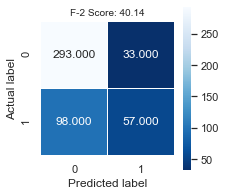

In [29]:
plt.figure(figsize=(3,3))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred), annot=True, fmt=".3f", linewidths=.2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F-2 Score: {0}'.format(round(metrics.fbeta_score(y_test, y_pred, beta=2)*100,2))
plt.title(all_sample_title, size = 10);

From the confusion matrix above, we can see that there are 98 FN and the f2 score is only 40%. This is a poor performing model.

### 2.1.2) LR with Upsampling Minority Class

Since the data is imbalanced, lets try with increasing the minority class count and then train the same LR model as above.

In [30]:
x = encoded.drop(["default_status"], axis=1)
y = encoded["default_status"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
            test_size=0.2, stratify=y, shuffle=True, random_state=123)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.array(x_train.tolist())
y_train = np.array(y_train.tolist())
x_test = np.array(x_test.tolist())
y_test = np.array(y_test.tolist())

from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

Counter({0: 1302, 1: 618})
Counter({0: 326, 1: 155})
1920
1920
481
481


The SMOTE technique is used to upsample the minority class. It can be seen that the initial y_train that had only 618 1's, has been upsampled to 1302 which is the same number as the 0's. Also only the training data has been upsampled.

In [31]:
sm = SMOTE(random_state = 5)
x_upsampled_train, y_upsampled_train = sm.fit_resample(x_train, y_train)

print(Counter(y_upsampled_train))
print(Counter(y_test))

print(len(x_upsampled_train))
print(len(y_upsampled_train))
print(len(x_test))
print(len(y_test))

Counter({0: 1302, 1: 1302})
Counter({0: 326, 1: 155})
2604
2604
481
481


In [32]:
lr = linear_model.LogisticRegression(C=1, solver='liblinear' , random_state=123)
lr.fit(x_upsampled_train, y_upsampled_train)
y_pred = lr.predict(x_test)
y_pred_prob = lr.predict_proba(x_test)[:,1]


print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred)*100,2))
print('Precision:', round(metrics.precision_score(y_test, y_pred)*100,2))
print('Recall:', round(metrics.recall_score(y_test, y_pred)*100,2))
print('f-beta score:', round(metrics.fbeta_score(y_test, y_pred, beta=2)*100,2))
print('AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 71.1
Precision: 53.67
Recall: 75.48
f-beta score: 69.81
AUC: 0.8038393033841282


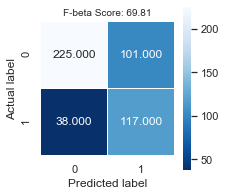

In [33]:
plt.figure(figsize=(3,3))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred), annot=True, fmt=".3f", linewidths=.2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F-beta Score: {0}'.format(round(metrics.fbeta_score(y_test, y_pred, beta=2)*100,2))
plt.title(all_sample_title, size = 10);

With help of SMOTE, there has been a drastic increase in the f2 score. Previously it was only 40% but now after upsampling, it is 69.8%. The number of FN has reduced to 38 from 98.

#### Since it is clear that it is better to use the upsampled dataset, in the next steps only the upsampled dataset will be used

### 2.1.3) Model Tuning & Identifying Threshold

In [34]:
# Fit and predict test class probabilities

lr = linear_model.LogisticRegression()
lr.fit(x_upsampled_train, y_upsampled_train)
y_pred = lr.predict(x_test)
y_test_probs = lr.predict_proba(x_test)[:,1]

f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find scores for each threshold
for p in probability_thresholds:
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    f1 = metrics.f1_score(y_test, y_test_preds)
    f0_5 = metrics.fbeta_score(y_test, y_test_preds, beta=0.5)
    f2 = metrics.fbeta_score(y_test, y_test_preds, beta=2)
    prec = metrics.precision_score(y_test, y_test_preds)
    rec = metrics.recall_score(y_test, y_test_preds)
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(prec)
    recall_scores.append(rec)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


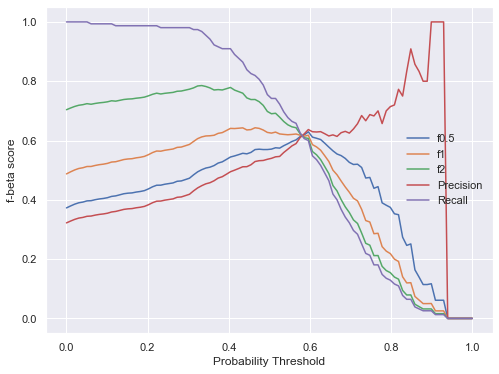

In [35]:
import matplotlib.pyplot as plt
# Plot f_beta, precision, recall curves
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f0_5_scores , label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right');

Selecting the threshold where the F2 score is the largest

In [36]:
max_position=np.argmax(f2_scores)
optimal_threshold=probability_thresholds[max_position]
optimal_threshold

0.33333333333333337

#### Finding optimal C value (hyperparameter tunning)

In [37]:
from sklearn import linear_model
from sklearn.metrics import fbeta_score
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1,10,100,1000]
for i in C:
    print("c=: ",i)
    clf = linear_model.LogisticRegression(C = i,solver='liblinear' )
    clf.fit(x_upsampled_train, y_upsampled_train)
    y_test_probs = clf.predict_proba(x_test)[:,1]
    y_test_pred = []
    
    for prob in y_test_probs:
        if prob > optimal_threshold:
            y_test_pred.append(1)
        else:
            y_test_pred.append(0)
    print("f2 score:",round(fbeta_score(y_test, y_test_pred,  beta=2, labels=None, pos_label=1)*100,2))

c=:  1e-05
f2 score: 70.39
c=:  0.0001
f2 score: 70.39
c=:  0.001
f2 score: 70.39
c=:  0.01
f2 score: 70.84
c=:  0.1
f2 score: 75.62
c=:  1
f2 score: 78.62
c=:  10
f2 score: 77.05
c=:  100
f2 score: 76.51
c=:  1000
f2 score: 76.51


Since the F2 score is highest for C=1, we will consider C to be 1

Building Logistic Regression model with obtained optimal C value

Accuracy: 60.71
Precision: 44.91
Recall: 96.77
f-beta score: 78.62
AUC: 0.8038393033841282


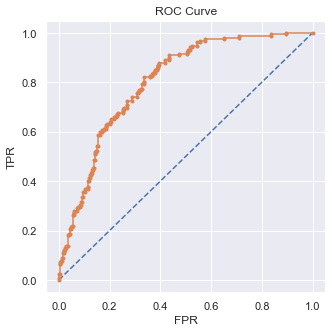

In [38]:
logmodel=linear_model.LogisticRegression(C=1,solver='liblinear' )
logmodel.fit(x_upsampled_train,y_upsampled_train)
y_pred_probs=logmodel.predict_proba(x_test)[:,1]
y_test_pred = []

for prob in y_pred_probs:
    if prob > optimal_threshold:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)

print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred)*100,2))
print('Precision:', round(metrics.precision_score(y_test, y_test_pred)*100,2))
print('Recall:', round( metrics.recall_score(y_test, y_test_pred)*100,2))
print('f-beta score:', round(fbeta_score(y_test, y_test_pred,  beta=2, labels=None, pos_label=1)*100,2))

# calculate the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)
# Calculate AUC
print('AUC:', metrics.roc_auc_score(y_test, y_pred_probs))

plt.plot([0, 1], [0, 1], ls = '--')
plt.plot(fpr, tpr, marker = '.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

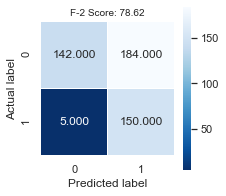

In [39]:
import seaborn as sns
plt.figure(figsize=(3,3))
sns.heatmap(metrics.confusion_matrix(y_test,y_test_pred), annot=True, fmt=".3f", linewidths=.2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F-2 Score: {0}'.format(round(metrics.fbeta_score(y_test, y_test_pred, beta=2)*100,2))
plt.title(all_sample_title, size = 10);

The recall for the model if very high. However, the precision is very low.

## 2.2)  Random Forest

### 2.2.1) RF Model Tuning & Identifying Threshold

In [40]:
x = encoded.drop(["default_status"], axis=1)
y = encoded["default_status"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
            test_size=0.2, stratify=y, shuffle=True, random_state=123)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.array(x_train.tolist())
y_train = np.array(y_train.tolist())
x_test = np.array(x_test.tolist())
y_test = np.array(y_test.tolist())

from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

Counter({0: 1302, 1: 618})
Counter({0: 326, 1: 155})
1920
1920
481
481


In [41]:
# upsample minority class
sm = SMOTE(random_state = 5)
x_upsampled_train, y_upsampled_train = sm.fit_resample(x_train, y_train)

In [42]:
# model with default parameters
default_model = ensemble.RandomForestClassifier(random_state=123)
default_model.fit(x_upsampled_train, y_upsampled_train)
y_pred = default_model.predict(x_test)
y_test_probs = default_model.predict_proba(x_test)[:,1]

f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find scores for each threshold
for p in probability_thresholds:
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    f1 = metrics.f1_score(y_test, y_test_preds)
    f0_5 = metrics.fbeta_score(y_test, y_test_preds, beta=0.5)
    f2 = metrics.fbeta_score(y_test, y_test_preds, beta=2)
    prec = metrics.precision_score(y_test, y_test_preds)
    rec = metrics.recall_score(y_test, y_test_preds)
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(prec)
    recall_scores.append(rec)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


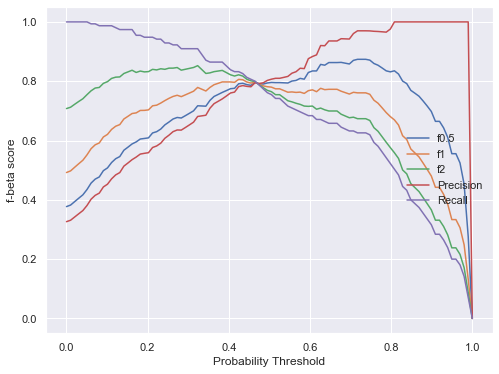

In [43]:
import matplotlib.pyplot as plt
# Plot f_beta, precision, recall curves
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f0_5_scores , label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right');

In [44]:
max_position=np.argmax(f2_scores)
optimal_threshold=probability_thresholds[max_position]
optimal_threshold

0.32323232323232326

Hyperparameter tuning using grid search

In [45]:
# parameter tuning using grid search
from sklearn.model_selection import GridSearchCV
f2_score = metrics.make_scorer(metrics.fbeta_score, beta=2)
scorer = metrics.make_scorer(metrics.fbeta_score, beta=2)
param_grid = {"n_estimators": [10,50,100,200,500] ,
              'max_depth': [5 ,10],
              'max_features': ['auto', 'log2',5,10],
              'min_samples_leaf': [1, 3],
              'min_samples_split': [2, 5]}

rf = ensemble.RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=f2_score, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(x_upsampled_train, y_upsampled_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


Accuracy: 86.07
Precision: 72.22
Recall: 92.26
f-beta score: 87.41
AUC: 0.95606570354245


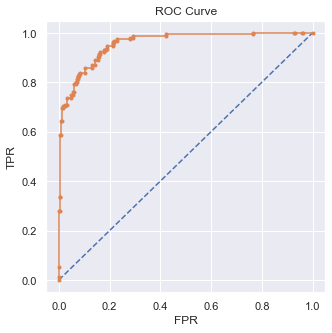

In [46]:
# evaluate model on testing data
best_model = grid_search.best_estimator_
y_pred_probs=best_model.predict_proba(x_test)[:,1]
y_test_pred = []

for prob in y_pred_probs:
    if prob > optimal_threshold:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)

print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred)*100,2))
print('Precision:', round(metrics.precision_score(y_test, y_test_pred)*100,2))
print('Recall:', round( metrics.recall_score(y_test, y_test_pred)*100,2))
print('f-beta score:', round(fbeta_score(y_test, y_test_pred,  beta=2, labels=None, pos_label=1)*100,2))

# calculate the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)
# Calculate AUC
print('AUC:', metrics.roc_auc_score(y_test, y_pred_probs))

plt.plot([0, 1], [0, 1], ls = '--')
plt.plot(fpr, tpr, marker = '.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

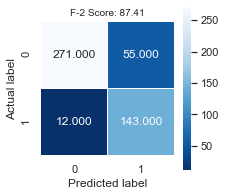

In [47]:
import seaborn as sns
plt.figure(figsize=(3,3))
sns.heatmap(metrics.confusion_matrix(y_test,y_test_pred), annot=True, fmt=".3f", linewidths=.2, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F-2 Score: {0}'.format(round(metrics.fbeta_score(y_test, y_test_pred, beta=2)*100,2))
plt.title(all_sample_title, size = 10);

###  2.3) Evaluation of Model

The above 'best_model' is the best performing random forest model with an accuracy of 86% and f2 score of 87%. This model will be used to predict the test data.

## 3) Feature Importance

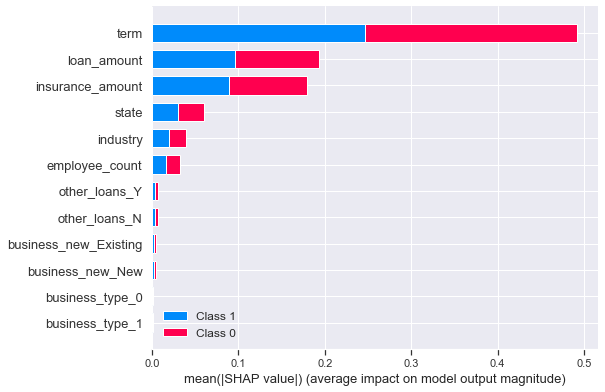

In [48]:
# finding feature importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_test, check_additivity=False)
shap.summary_plot(shap_values, x_test, plot_type="bar", feature_names=x.columns, show=False)
plt.show()

As from the top features identified, we can see that term, loan amount and the difference in loan and insured amount have contributed to the model's prediction.

## 4) Given Test Data Predictions

In [49]:
test_raw = pd.read_csv('data/test.csv')

#processing test data
test=test_raw
test[test.columns[10:12]] = test[test.columns[10:12]].replace('[\$,]', '', regex=True).astype(float)
test['business_type']=test['business_type'].apply(str)

test['id']=test['id'].apply(str)
test = test.drop(columns=['id'])
test = test.drop(columns=['location'])
test=test.drop(columns=['request_date'])
test = pd.get_dummies(test, columns = ['business_new', 'business_type','other_loans'])

test = test.merge(encodings1, how='left', on='industry')
test = test.merge(encodings2, how='left', on='state')
test.drop('industry', axis=1, inplace=True)
test.drop('state', axis=1, inplace=True)

test.rename(columns = {'default_status_x':'industry','default_status_y':'state'}, inplace = True)
test['insurance_amount'] = test['loan_amount']-test['insured_amount']
test=test.drop(columns=['insured_amount'])

In [50]:
y_pred_probs=best_model.predict_proba(test)[:,1]
y_test_pred = []

for prob in y_pred_probs:
    if prob > optimal_threshold:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)

In [51]:
predictions=test_raw
predictions['default_status']=y_test_pred
final=predictions[['id','default_status']]

In [52]:
final.to_csv('output.csv',index=False)